In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                            accuracy_score, precision_score, recall_score, 
                            f1_score, matthews_corrcoef)
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import joblib
from sklearn.utils import class_weight


In [140]:
# ============================================
# FUNCTION 1: Training History Visualization
# ============================================

def plot_training_history(history):
    """
    Plot training and validation metrics over epochs
    
    Usage:
        plot_training_history(history)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss Over Epochs')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy Over Epochs')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision Over Epochs')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall Over Epochs')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


# ============================================
# FUNCTION 2: Confusion Matrix
# ============================================

def plot_confusion_matrix(y_true, y_pred, classes=['Negative', 'Positive']):
    """
    Plot confusion matrix with annotations and percentages
    
    Usage:
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
        plot_confusion_matrix(y_test, y_pred)
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Add percentage annotations
    total = np.sum(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = (cm[i, j] / total) * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\n" + "="*50)
    print("CONFUSION MATRIX BREAKDOWN")
    print("="*50)
    print(f"True Negatives (TN):  {cm[0, 0]}")
    print(f"False Positives (FP): {cm[0, 1]}")
    print(f"False Negatives (FN): {cm[1, 0]}")
    print(f"True Positives (TP):  {cm[1, 1]}")
    print("="*50)


# ============================================
# FUNCTION 3: Classification Report
# ============================================

def print_classification_report(y_true, y_pred):
    """
    Print detailed classification metrics
    
    Usage:
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
        print_classification_report(y_test, y_pred)
    """
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(y_test, y_pred, 
                              target_names=['Negative', 'Positive']))


# ============================================
# FUNCTION 4: ROC Curve
# ============================================

def plot_roc_curve(y_true, y_pred_proba):
    """
    Plot ROC curve with AUC score
    
    Usage:
        y_pred_proba = model.predict(X_test)
        plot_roc_curve(y_test, y_pred_proba)
    
    Returns:
        roc_auc: AUC score
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', 
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nAUC Score: {roc_auc:.4f}")
    return roc_auc


# ============================================
# FUNCTION 5: Prediction Distribution
# ============================================

def plot_prediction_distribution(y_true, y_pred_proba):
    """
    Plot distribution of predicted probabilities
    
    Usage:
        y_pred_proba = model.predict(X_test)
        plot_prediction_distribution(y_test, y_pred_proba)
    """
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Histogram by true class
    plt.subplot(1, 2, 1)
    plt.hist(y_pred_proba[y_true == 0], bins=30, alpha=0.6, 
             label='True Negative', color='blue', edgecolor='black')
    plt.hist(y_pred_proba[y_true == 1], bins=30, alpha=0.6, 
             label='True Positive', color='red', edgecolor='black')
    plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, 
                label='Threshold (0.5)')
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Box plot
    plt.subplot(1, 2, 2)
    data_to_plot = [y_pred_proba[y_true == 0].flatten(), 
                    y_pred_proba[y_true == 1].flatten()]
    plt.boxplot(data_to_plot, tick_labels=['True Negative', 'True Positive'])
    plt.axhline(y=0.5, color='green', linestyle='--', linewidth=2, 
                label='Threshold (0.5)')
    plt.ylabel('Predicted Probability', fontsize=12)
    plt.title('Probability Distribution by True Class', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


# ============================================
# FUNCTION 6: Comprehensive Metrics Summary
# ============================================

def print_comprehensive_metrics(y_true, y_pred, y_pred_proba):
    """
    Print all evaluation metrics with interpretation
    
    Usage:
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        print_comprehensive_metrics(y_test, y_pred, y_pred_proba)
    """
    print("\n" + "="*60)
    print(" "*15 + "COMPREHENSIVE METRICS SUMMARY")
    print("="*60)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"Accuracy:              {accuracy:.4f}  ({accuracy*100:.2f}%)")
    print(f"Precision:             {precision:.4f}  ({precision*100:.2f}%)")
    print(f"Recall (Sensitivity):  {recall:.4f}  ({recall*100:.2f}%)")
    print(f"F1-Score:              {f1:.4f}")
    print(f"Matthews Corr Coef:    {mcc:.4f}")
    print(f"ROC AUC Score:         {roc_auc:.4f}")
    
    # Specificity
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    print(f"Specificity:           {specificity:.4f}  ({specificity*100:.2f}%)")
    
    print("="*60)
    
    # Interpretation
    print("\nINTERPRETATION:")
    print("-" * 60)
    if accuracy > 0.85:
        print("✓ Excellent accuracy!")
    elif accuracy > 0.75:
        print("✓ Good accuracy")
    else:
        print("⚠ Room for improvement in accuracy")
    
    if f1 > 0.80:
        print("✓ Excellent balance between precision and recall")
    elif f1 > 0.70:
        print("✓ Good balance between precision and recall")
    else:
        print("⚠ Consider tuning the model for better precision/recall balance")
    
    if roc_auc > 0.90:
        print("✓ Excellent discrimination ability")
    elif roc_auc > 0.80:
        print("✓ Good discrimination ability")
    else:
        print("⚠ Model needs improvement in distinguishing classes")
    
    print("="*60)


# ============================================
# FUNCTION 7: Threshold Analysis
# ============================================

def plot_threshold_analysis(y_true, y_pred_proba):
    """
    Analyze different threshold values to find optimal threshold
    
    Usage:
        y_pred_proba = model.predict(X_test)
        plot_threshold_analysis(y_test, y_pred_proba)
    
    Returns:
        optimal_threshold: Best threshold for F1-score
    """
    thresholds = np.arange(0.1, 1.0, 0.05)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba > threshold).astype(int).flatten()
        precisions.append(precision_score(y_true, y_pred_thresh))
        recalls.append(recall_score(y_true, y_pred_thresh))
        f1_scores.append(f1_score(y_true, y_pred_thresh))
    
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
    plt.plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2)
    plt.axvline(x=0.5, color='black', linestyle='--', 
                label='Default Threshold (0.5)', linewidth=2)
    
    # Find optimal F1 threshold
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    plt.axvline(x=optimal_threshold, color='purple', linestyle='--', 
                label=f'Optimal F1 Threshold ({optimal_threshold:.2f})', linewidth=2)
    
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Metrics vs Classification Threshold', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nOptimal threshold for F1-Score: {optimal_threshold:.3f}")
    print(f"F1-Score at optimal threshold: {f1_scores[optimal_idx]:.4f}")
    
    return optimal_threshold


In [141]:
arff_file = arff.loadarff("./datasets/dataset_37_diabetes.arff")

In [142]:
df = pd.DataFrame(arff_file[0])
df.dropna()

df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


In [143]:
df["class"] = df["class"].str.decode("utf-8")

df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,tested_positive
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,tested_negative
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,tested_positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,tested_positive


In [157]:
X = df.drop(["class"],axis=1)
y = df["class"]

joblib.dump(list(X.columns), "./models/diabetes_features.joblib")


['./models/diabetes_features.joblib']

In [158]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "./models/diabetes_labeler.joblib")

scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, "./models/diabetes_scaler.joblib")

y.shape,X.shape

((768,), (768, 8))

In [146]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [147]:
model = tf.keras.Sequential([
      tf.keras.layers.Input(X_train[0].shape),
            tf.keras.layers.Dense(
                256,
                activation=tf.keras.layers.LeakyReLU(negative_slope=0.01),
            ),
            tf.keras.layers.Dropout(0.3),
            
              tf.keras.layers.Dense(
                256,
                activation=tf.keras.layers.LeakyReLU(negative_slope=0.01),
            ),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(
                256,
                activation=tf.keras.layers.LeakyReLU(negative_slope=0.01),
            ),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, 
                activation=tf.nn.sigmoid),
])

class_weights_values = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_values))

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,145 (524.00 KB)

 Trainable params: 134,145 (524.00 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        class_weight=class_weights,
        verbose=1,
    )

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4521 - loss: 0.6694 - precision: 0.3835 - recall: 0.9588 - val_accuracy: 0.6179 - val_loss: 0.6564 - val_precision: 0.4824 - val_recall: 0.9318
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5947 - loss: 0.6448 - precision: 0.4559 - recall: 0.8824 - val_accuracy: 0.7154 - val_loss: 0.6183 - val_precision: 0.5672 - val_recall: 0.8636
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6721 - loss: 0.6123 - precision: 0.5158 - recall: 0.8647 - val_accuracy: 0.7480 - val_loss: 0.5799 - val_precision: 0.6102 - val_recall: 0.8182
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7067 - loss: 0.5875 - precision: 0.5542 - recall: 0.7824 - val_accuracy: 0.7480 - val_loss: 0.5481 - val_precision: 0.6140 - val_recall: 0.7955
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7332 - loss: 0.5665 - precision: 0.5816 - recall: 0.8176 - val_accuracy: 0.7642 - val_loss: 0.5171 - val

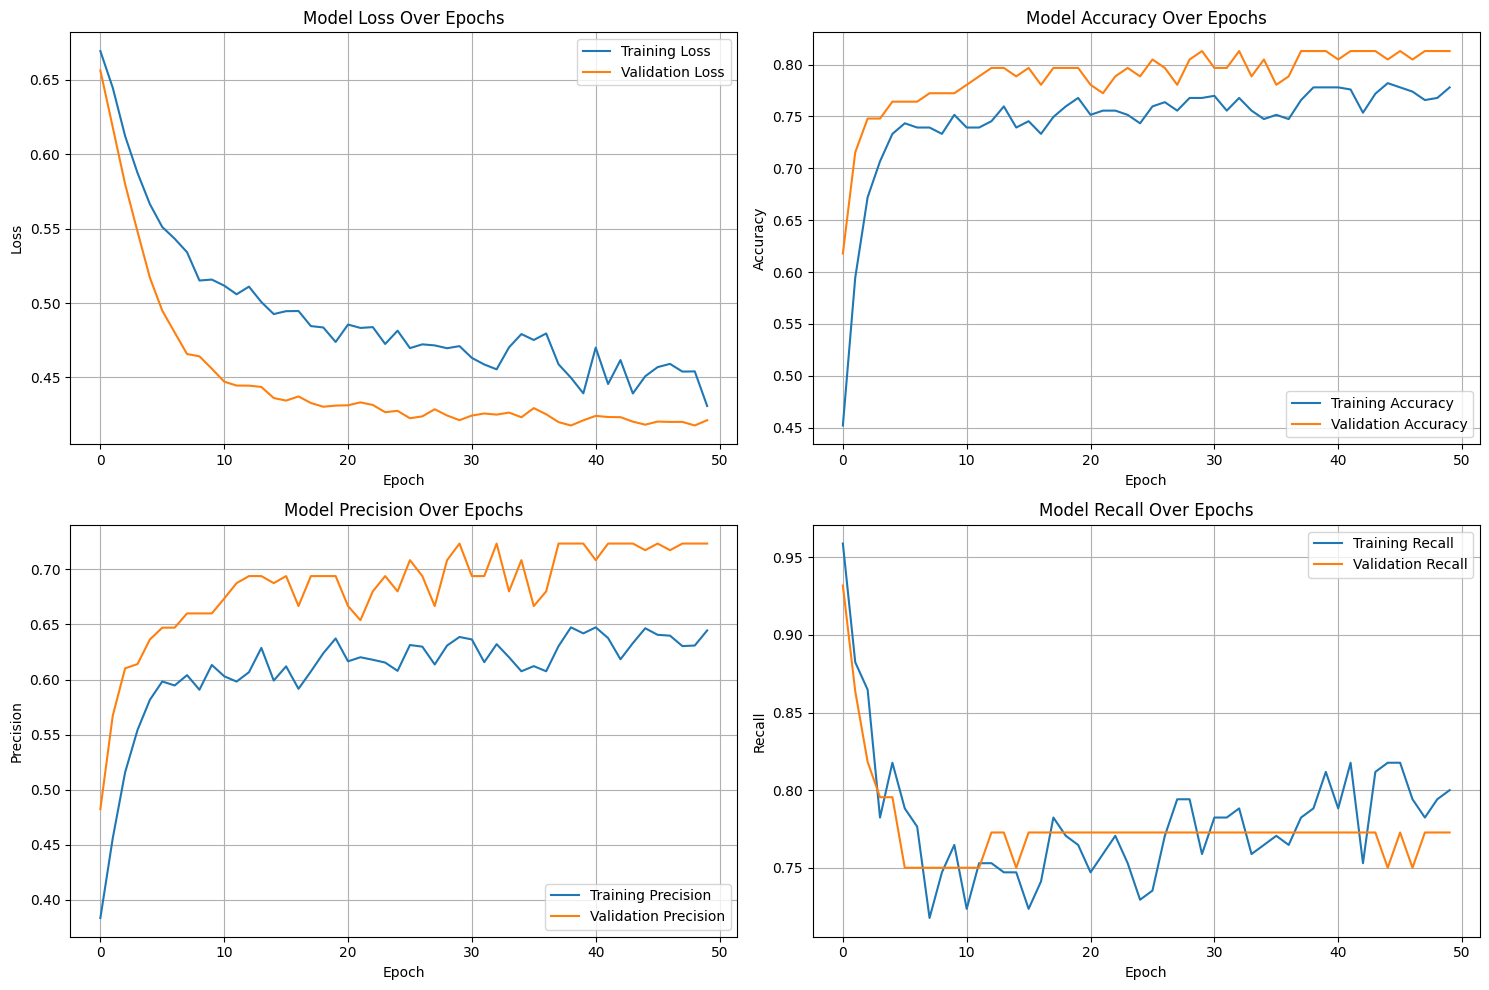

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002460DBB79C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


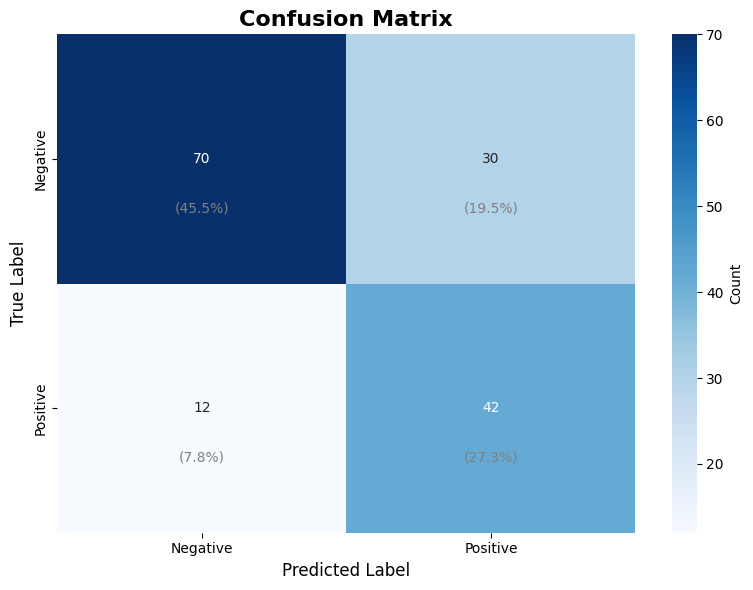


CONFUSION MATRIX BREAKDOWN
True Negatives (TN):  70
False Positives (FP): 30
False Negatives (FN): 12
True Positives (TP):  42

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.85      0.70      0.77       100
    Positive       0.58      0.78      0.67        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.76      0.73      0.73       154



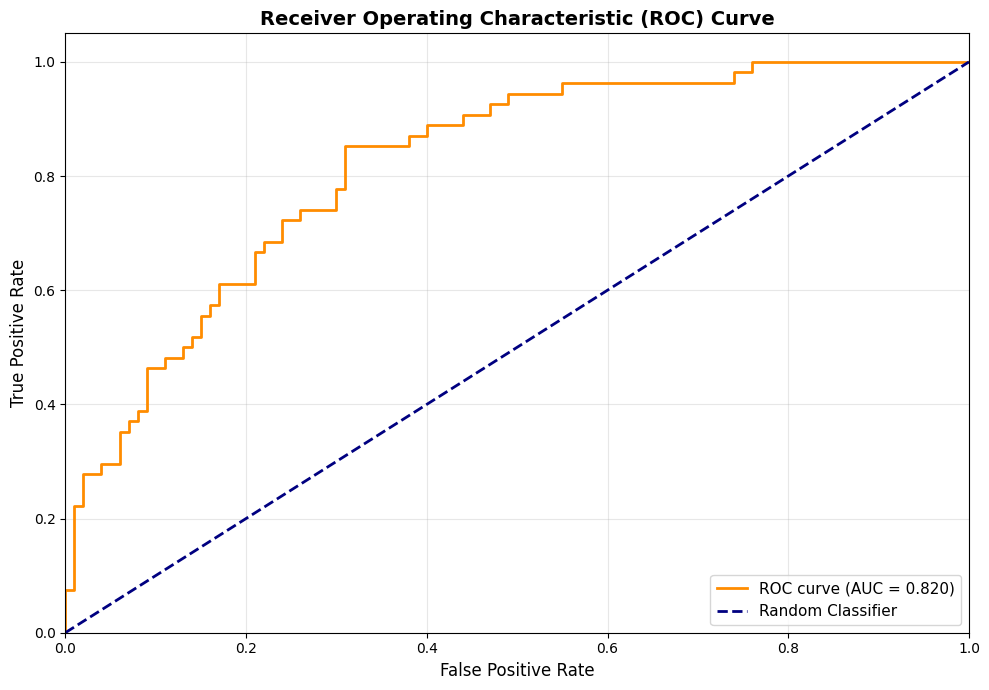


AUC Score: 0.8202


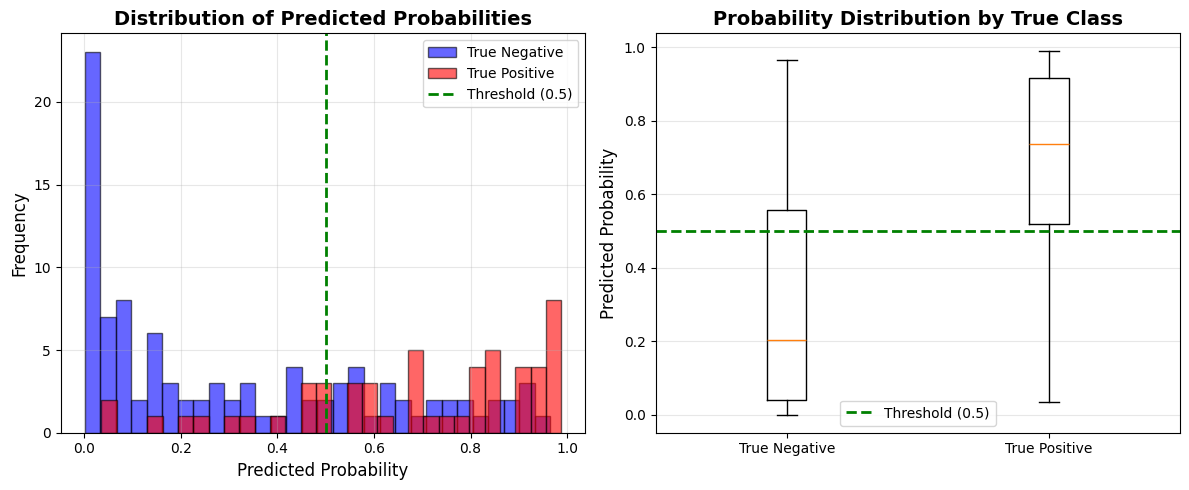


               COMPREHENSIVE METRICS SUMMARY
Accuracy:              0.7273  (72.73%)
Precision:             0.5833  (58.33%)
Recall (Sensitivity):  0.7778  (77.78%)
F1-Score:              0.6667
Matthews Corr Coef:    0.4569
ROC AUC Score:         0.8202
Specificity:           0.7000  (70.00%)

INTERPRETATION:
------------------------------------------------------------
⚠ Room for improvement in accuracy
⚠ Consider tuning the model for better precision/recall balance
✓ Good discrimination ability


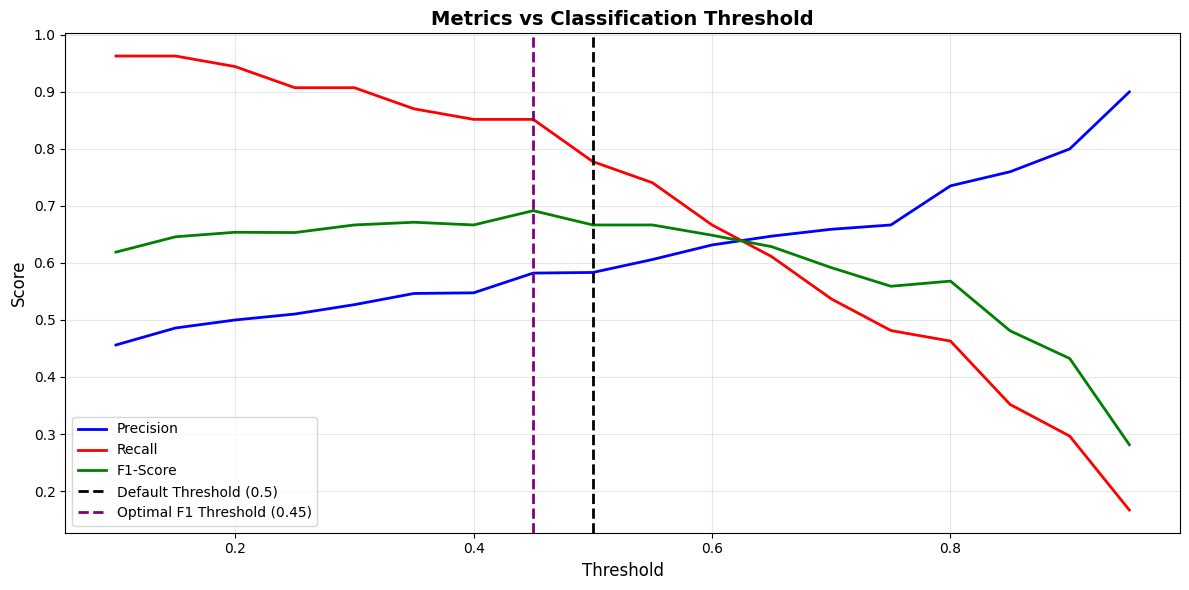


Optimal threshold for F1-Score: 0.450
F1-Score at optimal threshold: 0.6917


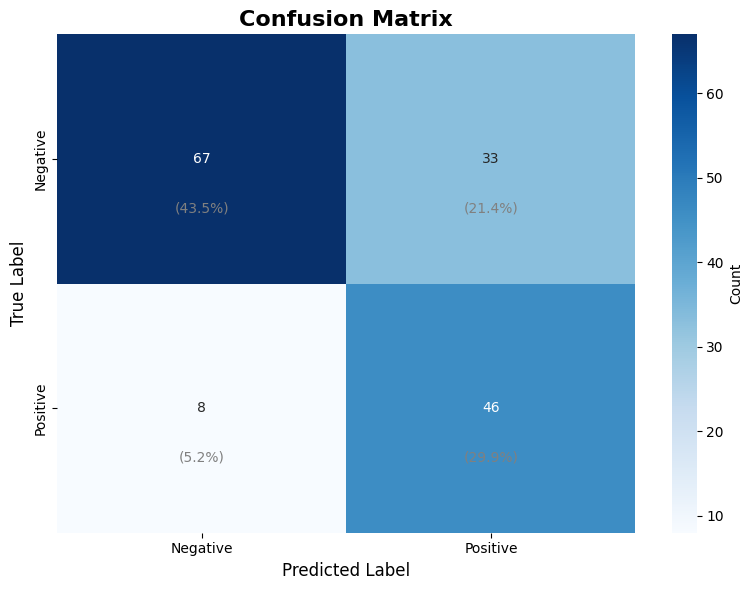


CONFUSION MATRIX BREAKDOWN
True Negatives (TN):  67
False Positives (FP): 33
False Negatives (FN): 8
True Positives (TP):  46


In [149]:
plot_training_history(history)
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

plot_confusion_matrix(y_test, y_pred)

print_classification_report(y_test, y_pred)

roc_auc = plot_roc_curve(y_test, y_pred_proba)

plot_prediction_distribution(y_test, y_pred_proba)

print_comprehensive_metrics(y_test, y_pred, y_pred_proba)

optimal_threshold = plot_threshold_analysis(y_test, y_pred_proba)

y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int).flatten()
plot_confusion_matrix(y_test, y_pred_optimal)

In [150]:
model.save("models/diabitics.keras")